In [3]:
import mxnet as mx
from gluoncv.model_zoo import get_model
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet.gluon.data.vision import transforms
from mxnet.gluon import utils as gutils
import time
from tools.loss import *
import logging

GPU_COUNT = 2
ctx = [mx.gpu(i) for i in range(GPU_COUNT)]

per_gup_batch_size = 16
batch_size = GPU_COUNT * per_gup_batch_size
train_epoch = 20
classes = 25


def get_fine_tune_model(pretrained=None):
    if pretrained == None:
        fine_tune_net = get_model('xception', pretrained=True)
    else:
        fine_tune_net = get_model('xception', pretrained=False)
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(fine_tune_net.conv1)
        net.add(fine_tune_net.bn1)
        net.add(fine_tune_net.relu)
        net.add(fine_tune_net.conv2)
        net.add(fine_tune_net.bn2)
        net.add(fine_tune_net.relu)
        net.add(fine_tune_net.block1)
        net.add(fine_tune_net.relu)
        net.add(fine_tune_net.block2)
        net.add(fine_tune_net.block3)
        net.add(fine_tune_net.midflow)
        net.add(fine_tune_net.block20)
        net.add(fine_tune_net.relu)
        net.add(fine_tune_net.conv3)
        net.add(fine_tune_net.bn3)
        net.add(fine_tune_net.relu)
        net.add(fine_tune_net.conv4)
        net.add(fine_tune_net.bn4)
        net.add(fine_tune_net.relu)
        net.add(fine_tune_net.conv5)
        net.add(fine_tune_net.bn5)
        net.add(fine_tune_net.relu)
        net.add(fine_tune_net.avgpool)
        net.add(fine_tune_net.flat)
        net.add(gluon.nn.Dropout(0.5))
        net.add(gluon.nn.Dense(25))
        if pretrained == 'best':
            net.load_parameters('weights/best_xception.params')
        elif pretrained == 'last':
            net.load_parameters('weights/last_xception.params')
        else :
            net[-1].collect_params().initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    net.collect_params().reset_ctx(ctx=ctx)
    return net

net = get_fine_tune_model('last')

train_transform= transforms.Compose([
                      transforms.Resize(299),
                      transforms.RandomSaturation(0.2),
                      transforms.RandomContrast(0.2),
                      transforms.RandomFlipLeftRight(),
                      transforms.RandomFlipTopBottom(),
                      transforms.ToTensor(),
                                  ])


val_transform= transforms.Compose([
                      transforms.Resize(299),
                      # transforms.RandomSaturation(0.2),
                      # transforms.RandomContrast(0.2),
                      # transforms.RandomFlipLeftRight(),
                      # transforms.RandomFlipTopBottom(),
                      transforms.ToTensor(),
                                  ])

train_data = gluon.data.vision.ImageRecordDataset('img_file/train.rec').transform_first(train_transform)
train_loader = gluon.data.DataLoader(train_data, batch_size=batch_size,num_workers = 4)
val_data = gluon.data.vision.ImageRecordDataset('img_file/val.rec').transform_first(val_transform)
val_loader = gluon.data.DataLoader(val_data, batch_size=batch_size,num_workers = 4)




In [4]:

def accuracy(output,label):
    acc = mx.metric.Accuracy()
    predictions = mx.nd.argmax(output, axis=1)
    # print (label)
    # print (predictions)
    acc.update(preds=predictions, labels=label)
    # print (acc.get()[1])
    return acc.get()[1]


def evaluate_accuracy(data_iterator, net, ctx=ctx):
    acc = 0.
    for i,(X, y) in enumerate(data_iterator):
        X = X / 255
        data = gutils.split_and_load(X, ctx, even_split=False)
        label = gutils.split_and_load(y, ctx, even_split=False)

        # output = net(data.as_in_context(ctx))
        output = [(net(data), label) for data, label in zip(data, label)]
        for result in output:
            acc += accuracy(result[0],result[1])
        # acc += accuracy(output, label.as_in_context(ctx))
        # if i + 1 >= 10 :
        #     return acc / (10 * len(ctx))
    return acc / (len(data_iterator) * len(ctx))


def ConfusionMatrix(output,label):
    import numpy as np
    from sklearn.metrics import confusion_matrix
    predictions = mx.nd.argmax(output, axis=1)
    cm=confusion_matrix(label.asnumpy(), predictions.asnumpy(),labels = range(25))
    # print (acc.get()[1])
    return cm



def evaluate_confusion_matrix(data_iterator,net,ctx = ctx):
    import numpy as np
    cm = np.zeros([classes,classes])
    for i,(X, y) in enumerate(data_iterator):
        X = X / 255
        data = gutils.split_and_load(X, ctx, even_split=False)
        label = gutils.split_and_load(y, ctx, even_split=False)

        # output = net(data.as_in_context(ctx))
        output = [(net(data), label) for data, label in zip(data, label)]
        for result in output:
            cm += ConfusionMatrix(result[0],result[1])
        # acc += accuracy(output, label.as_in_context(ctx))
        # if i + 1 >= 10 :
        #     return acc / (10 * len(ctx))
    return cm






def train(num_gpus = GPU_COUNT, batch_size = batch_size, lr = 0.01 , train_epoch = train_epoch):
    # train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    train_iter, test_iter = train_loader , val_loader
    ctx = [mx.gpu(i) for i in range(num_gpus)]
    print('running on:', ctx)
    # net.initialize(init=init.Normal(sigma=0.01), ctx=ctx, force_reinit=True)

    loss = gluon.loss.SoftmaxCrossEntropyLoss()

    best_acc = 0.

    # loss = L2Softmax(classes = 25,alpha = 10)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

    for epoch in range(train_epoch):
        train_loss = 0.
        start = time.time()
        for i,(X, y) in enumerate(train_iter):
            X = X / 255
            gpu_Xs = gutils.split_and_load(X, ctx,even_split = False)
            gpu_ys = gutils.split_and_load(y, ctx,even_split = False)
            with autograd.record():
                ls = [loss(net(gpu_X), gpu_y)
                      for gpu_X, gpu_y in zip(gpu_Xs, gpu_ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            ls_list = [nd.mean(i).asscalar() for i in ls]
            train_loss += sum(ls_list) / len(ls_list)


            if (i + 1) % 20 == 0:
                #打印训练日志
                print ("epoch[{epoch}]  batch_num[{batch_num}]  epochtrain_loss : {loss}".format(
                    epoch = epoch + 1,batch_num = i +1 ,loss = train_loss/(i +1)))
                # test_acc = evaluate_accuracy(test_iter, net, ctx)
                # train_time = time.time() - start
                # print('epoch %d, time %.1f sec, test acc %.7f' % (
                #     epoch + 1, train_time, test_acc))
                # net.save_parameters('weights/best_xception.params')
        nd.waitall()
        train_time = time.time() - start
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, time %.1f sec, test acc %.2f' % (
            epoch + 1, train_time, test_acc))
        if test_acc > best_acc:
            best_acc = test_acc
            net.save_parameters('weights/best_xception.params')
        if ( epoch + 1 ) % 5 == 0 :
            net.export('weights/gluon_xception', epoch=epoch + 1)
        net.save_parameters('weights/last_xception.params')


def eval(num_gpus = GPU_COUNT, batch_size = batch_size, lr = 0.01):
    # train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    train_iter, test_iter = train_loader , val_loader
    ctx = [mx.gpu(i) for i in range(num_gpus)]
    print('running on:', ctx)

    # test_acc = evaluate_accuracy(test_iter, net, ctx)
    test_cm = evaluate_confusion_matrix(test_iter, net, ctx)
#     print('test acc %.7f' % ( test_acc ))
    print(test_cm)
    return test_cm

In [5]:
test_cm = eval()

running on: [gpu(0), gpu(1)]
[[5.4500e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  5.0000e+00]
 [0.0000e+00 1.5450e+03 7.0000e+00 9.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 3.1000e+01 2.9000e+01 9.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  4.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [0.0000e+00 2.0000e+01 7.1000e+02 0.0000e+00 0.0000e+00 0.0000e+00
  2.6000e+01 1.8000e+01 1.8000e+01 1.4000e+01 0.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [0.0000e+00 8.0000e+00 0.0000e+00 4.5140e+03 0.0000e+00 0.0000e+00
  1.0000e+00 1.3000e+01 0.0000e+00 1.0000e+00

ValueError: Must pass 2-d input

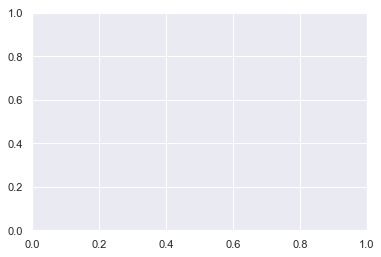

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.set()
f,ax=plt.subplots()


sns.heatmap(test_cm,annot=True,ax=ax) #画热力图

ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.show()

In [23]:
viz.plot_network(net)

/home/lin/anaconda3/lib/python3.5/site-packages/mxnet/visualization.py:301: RuntimeWarning: There are multiple variables with the same name in your graph, this may result in cyclic graph. Repeated names: xception655_relu5_fwd,xception655_relu9_fwd,xception655_relu11_fwd,xception655_relu12_fwd,xception655_relu13_fwd,xception655_relu0_fwd,xception655_relu18_fwd,xception655_relu10_fwd,xception655_relu4_fwd,xception655_relu16_fwd,xception655_relu17_fwd,xception655_relu14_fwd,xception655_relu6_fwd,xception655_relu7_fwd,xception655_relu3_fwd,xception655_relu8_fwd,xception655_relu2_fwd,xception655_relu15_fwd,xception655_relu19_fwd,xception655_relu20_fwd,xception655_relu1_fwd
  warnings.warn(warning_message, RuntimeWarning)


In [24]:
test(ctx, net, val_loader)

TypeError: copyto does not support type <class 'list'>

RuntimeError: Parameter 'softmax_label' has not been initialized

ValueError: Xavier initializer cannot be applied to vector softmax_label. It requires at least 2D.